In [ ]:
import multiprocessing

# Get the number of CPU cores
num_cores = multiprocessing.cpu_count()

print(f"Number of available CPU cores: {num_cores}")

Number of available CPU cores: 2


In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder.master(f"local[{num_cores}]")\
          .appName("AdultCSVData")\
          .config("spark.executor.memory", "8g") \
          .getOrCreate()


In [ ]:
df = spark.read.csv("/content/adult.csv",inferSchema=True,header=True)

In [ ]:
df.show()

+---+----------------+------+------------+-------------+--------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|   education|education.num|marital.status|       occupation|  relationship| race|   sex|capital.gain|capital.loss|hours.per.week|native.country|income|
+---+----------------+------+------------+-------------+--------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| 90|               ?| 77053|     HS-grad|            9|       Widowed|                ?| Not-in-family|White|Female|           0|        4356|            40| United-States| <=50K|
| 82|         Private|132870|     HS-grad|            9|       Widowed|  Exec-managerial| Not-in-family|White|Female|           0|        4356|            18| United-States| <=50K|
| 66|               ?|186061|Some-college|           10|       Widowed|                ?|     U

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education.num: integer (nullable = true)
 |-- marital.status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital.gain: integer (nullable = true)
 |-- capital.loss: integer (nullable = true)
 |-- hours.per.week: integer (nullable = true)
 |-- native.country: string (nullable = true)
 |-- income: string (nullable = true)



In [ ]:
renamed_cols = ['age','workclass','final_weight','education','education_num',
                'marital_status','occupation','relationship','race','sex','capital_gain',
                'capital_loss','hours_per_week','native_country','income']

#Rename columns

df = df.toDF(*renamed_cols)
df.show()

+---+----------------+------------+------------+-------------+--------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|final_weight|   education|education_num|marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+----------------+------------+------------+-------------+--------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| 90|               ?|       77053|     HS-grad|            9|       Widowed|                ?| Not-in-family|White|Female|           0|        4356|            40| United-States| <=50K|
| 82|         Private|      132870|     HS-grad|            9|       Widowed|  Exec-managerial| Not-in-family|White|Female|           0|        4356|            18| United-States| <=50K|
| 66|               ?|      186061|Some-college|           10|   

In [ ]:
df.replace('?',None).show()

+---+----------------+------------+------------+-------------+--------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|final_weight|   education|education_num|marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+----------------+------------+------------+-------------+--------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| 90|            NULL|       77053|     HS-grad|            9|       Widowed|             NULL| Not-in-family|White|Female|           0|        4356|            40| United-States| <=50K|
| 82|         Private|      132870|     HS-grad|            9|       Widowed|  Exec-managerial| Not-in-family|White|Female|           0|        4356|            18| United-States| <=50K|
| 66|            NULL|      186061|Some-college|           10|   

In [ ]:
from pyspark.sql.functions import col, sum, when

In [ ]:
from pyspark.sql.functions import col, sum

# List to store results
null_counts = []

null_counts = [(column, df.filter(col(column).isNull()).count()) for column in df.columns]

In [ ]:
null_counts

[('age', 0),
 ('workclass', 0),
 ('final_weight', 0),
 ('education', 0),
 ('education_num', 0),
 ('marital_status', 0),
 ('occupation', 0),
 ('relationship', 0),
 ('race', 0),
 ('sex', 0),
 ('capital_gain', 0),
 ('capital_loss', 0),
 ('hours_per_week', 0),
 ('native_country', 0),
 ('income', 0)]

In [ ]:
import numpy as np
df = df.replace('?',None)

null_counts = []

null_counts = [(column, df.filter(col(column).isNull()).count()) for column in df.columns]
null_counts

[('age', 0),
 ('workclass', 1836),
 ('final_weight', 0),
 ('education', 0),
 ('education_num', 0),
 ('marital_status', 0),
 ('occupation', 1843),
 ('relationship', 0),
 ('race', 0),
 ('sex', 0),
 ('capital_gain', 0),
 ('capital_loss', 0),
 ('hours_per_week', 0),
 ('native_country', 583),
 ('income', 0)]

In [ ]:
df.printSchema()# So all the categorical columns have null values

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- final_weight: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [ ]:
def stratified_split(data,ratios=[0.8,0.2],target_col='income'):
  pos_sample = data.filter(col(target_col)=='>50K')
  neg_sample = data.filter(col(target_col)=='<=50K')

  train_pos, test_pos = pos_sample.randomSplit(ratios, seed=42)
  train_neg, test_neg = neg_sample.randomSplit(ratios, seed=42)

  train = train_pos.union(train_neg)
  test = test_pos.union(test_neg)

  return train, test

In [ ]:
Train, Test = stratified_split(df)

In [ ]:
print(Train.filter(col('income')=='>50K').count())
print(Train.filter(col('income')=='<=50K').count())

6343
19798


In [ ]:
print(Test.filter(col('income')=='>50K').count())
print(Test.filter(col('income')=='<=50K').count())

1498
4922


In [ ]:
!pip install kmodes
from kmodes.kprototypes import KPrototypes

# Handle Missing Values using KModes

In [ ]:
def fillMissingValues(data,num_clusters=3):
  """
  input: Spark Dataframe, num_clusters: for number of clusters in Kprototypes
  returns: Spark Dataframe
  """
  pandas_data = data.toPandas()
  target = pandas_data.pop('income')

  missing_cols = pandas_data.columns[pandas_data.isnull().sum()>0]

  print("Columns with missing values : ",missing_cols.tolist())

  #get the data from missing cols

  missing_data_cols = pandas_data[missing_cols]

  #drop the missing cols

  pandas_data.drop(missing_cols,axis=1,inplace=True)

  # get the categorical columns

  object_columns = pandas_data.select_dtypes(include=['object']).columns

  #get the column indices

  object_column_indices = [pandas_data.columns.get_loc(col) for col in object_columns]

  print("Categorical columns with no missing values : ",object_column_indices)

  #print(num_clusters)

  kproto = KPrototypes(n_clusters=num_clusters, init='Cao', verbose=1, n_init=1)

  # Fit the K-Prototypes model using the entire dataset except the target and the missing columns

  clusters = kproto.fit_predict(pandas_data, categorical = object_column_indices)

  #print(clusters)


  pandas_data['Cluster'] = clusters

  #get back the missing column data

  pandas_data[missing_cols] = missing_data_cols

  for cluster_id in range(num_clusters):
    #print("Cluster id : ", cluster_id)
    cluster_data = pandas_data[pandas_data['Cluster'] == cluster_id]

    # Mode for each categorical variable
    cluster_modes = cluster_data.mode().iloc[0]

    #print(cluster_modes[missing_cols])

    # Impute missing values for the cluster
    for col in missing_cols:
      #print("Filling column : ",col)
      pandas_data.loc[pandas_data['Cluster'] == cluster_id,col] = pandas_data.loc[pandas_data['Cluster'] == cluster_id, col].fillna(cluster_modes[col])

  pandas_data.drop('Cluster',axis=1,inplace=True)

  pandas_data['income'] = target

  spark_data = spark.createDataFrame(pandas_data)

  return spark_data

In [ ]:
Imputed_Train = fillMissingValues(Train,5)

Columns with missing values :  ['workclass', 'occupation', 'native_country']
Categorical columns with no missing values :  [2, 4, 5, 6, 7]
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 5999, ncost: 52731096858568.47
Run: 1, iteration: 2/100, moves: 4042, ncost: 45674819053653.164
Run: 1, iteration: 3/100, moves: 3684, ncost: 41419223983623.92
Run: 1, iteration: 4/100, moves: 3021, ncost: 38463101092453.51
Run: 1, iteration: 5/100, moves: 2354, ncost: 36426631057478.7
Run: 1, iteration: 6/100, moves: 1792, ncost: 34793941405268.164
Run: 1, iteration: 7/100, moves: 1417, ncost: 33602114931003.293
Run: 1, iteration: 8/100, moves: 1014, ncost: 32963487327406.04
Run: 1, iteration: 9/100, moves: 781, ncost: 32537824974550.984
Run: 1, iteration: 10/100, moves: 627, ncost: 32294451511327.844
Run: 1, iteration: 11/100, moves: 513, ncost: 32160631264502.9

In [ ]:
Train.show()

+---+----------------+------------+------------+-------------+------------------+-----------------+--------------+------------------+------+------------+------------+--------------+------------------+------+
|age|       workclass|final_weight|   education|education_num|    marital_status|       occupation|  relationship|              race|   sex|capital_gain|capital_loss|hours_per_week|    native_country|income|
+---+----------------+------------+------------+-------------+------------------+-----------------+--------------+------------------+------+------------+------------+--------------+------------------+------+
| 19|            NULL|      200790|        12th|            8|Married-civ-spouse|             NULL|Other-relative|             White|Female|       15024|           0|            40|     United-States|  >50K|
| 19|         Private|      323605|     7th-8th|            4|     Never-married|    Other-service| Not-in-family|             White|  Male|           0|           0|  

In [ ]:
Imputed_Train.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26141 entries, 0 to 26140
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26141 non-null  int64 
 1   final_weight    26141 non-null  int64 
 2   education       26141 non-null  object
 3   education_num   26141 non-null  int64 
 4   marital_status  26141 non-null  object
 5   relationship    26141 non-null  object
 6   race            26141 non-null  object
 7   sex             26141 non-null  object
 8   capital_gain    26141 non-null  int64 
 9   capital_loss    26141 non-null  int64 
 10  hours_per_week  26141 non-null  int64 
 11  workclass       26141 non-null  object
 12  occupation      26141 non-null  object
 13  native_country  26141 non-null  object
 14  income          26141 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.0+ MB


In [ ]:
Imputed_Train.show()

+---+------------+------------+-------------+------------------+--------------+------------------+------+------------+------------+--------------+----------------+-----------------+------------------+------+
|age|final_weight|   education|education_num|    marital_status|  relationship|              race|   sex|capital_gain|capital_loss|hours_per_week|       workclass|       occupation|    native_country|income|
+---+------------+------------+-------------+------------------+--------------+------------------+------+------------+------------+--------------+----------------+-----------------+------------------+------+
| 19|      200790|        12th|            8|Married-civ-spouse|Other-relative|             White|Female|       15024|           0|            40|         Private|     Craft-repair|     United-States|  >50K|
| 19|      323605|     7th-8th|            4|     Never-married| Not-in-family|             White|  Male|           0|           0|            60|         Private|    O

In [ ]:
Imputed_Test = fillMissingValues(Test,5)

Columns with missing values :  ['workclass', 'occupation', 'native_country']
Categorical columns with no missing values :  [2, 4, 5, 6, 7]
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 728, ncost: 13076713413180.285
Run: 1, iteration: 2/100, moves: 967, ncost: 12220798325446.799
Run: 1, iteration: 3/100, moves: 980, ncost: 11326000735296.748
Run: 1, iteration: 4/100, moves: 884, ncost: 10487326599892.021
Run: 1, iteration: 5/100, moves: 611, ncost: 9968908772815.041
Run: 1, iteration: 6/100, moves: 465, ncost: 9513049499696.225
Run: 1, iteration: 7/100, moves: 376, ncost: 9073554866282.297
Run: 1, iteration: 8/100, moves: 335, ncost: 8728409149643.6
Run: 1, iteration: 9/100, moves: 252, ncost: 8520985127761.554
Run: 1, iteration: 10/100, moves: 200, ncost: 8408501300061.61
Run: 1, iteration: 11/100, moves: 158, ncost: 8329243077159.718
Run: 1, i

In [ ]:
Imputed_Test.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             6420 non-null   int64 
 1   final_weight    6420 non-null   int64 
 2   education       6420 non-null   object
 3   education_num   6420 non-null   int64 
 4   marital_status  6420 non-null   object
 5   relationship    6420 non-null   object
 6   race            6420 non-null   object
 7   sex             6420 non-null   object
 8   capital_gain    6420 non-null   int64 
 9   capital_loss    6420 non-null   int64 
 10  hours_per_week  6420 non-null   int64 
 11  workclass       6420 non-null   object
 12  occupation      6420 non-null   object
 13  native_country  6420 non-null   object
 14  income          6420 non-null   object
dtypes: int64(6), object(9)
memory usage: 752.5+ KB


## Check the class samples

In [ ]:
Imputed_Train.groupby('income').count().toPandas()

,income,count
0,<=50K,19798
1,>50K,6343


In [ ]:
Imputed_Test.groupby('income').count().toPandas()

,income,count
0,<=50K,4922
1,>50K,1498


In [ ]:
Imputed_Train.printSchema()

root
 |-- age: long (nullable = true)
 |-- final_weight: long (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: long (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: long (nullable = true)
 |-- capital_loss: long (nullable = true)
 |-- hours_per_week: long (nullable = true)
 |-- workclass: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [ ]:
categorical_cols = []
index_categorical_cols = []
ohe_categorical_cols = []

numerical_cols = []
numerical_cols_scaled = []

for col, dtype in Imputed_Train.dtypes:
  if dtype=='string':
    categorical_cols.append(col)
    index_categorical_cols.append(col+"Index")
    ohe_categorical_cols.append(col+"_ohv")
  else:
    numerical_cols.append(col)


print(categorical_cols)
print(numerical_cols)

['education', 'marital_status', 'relationship', 'race', 'sex', 'workclass', 'occupation', 'native_country', 'income']
['age', 'final_weight', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_categorical_cols)# Apply only string indexer to the income no One Hot encoding
encoder = OneHotEncoder(inputCols = indexer.getOutputCols()[:-1], outputCols = ohe_categorical_cols[:-1])
vector_assembler_1 = VectorAssembler(inputCols = numerical_cols, outputCol = 'InputFeatures')
scaler = MinMaxScaler(inputCol = 'InputFeatures', outputCol = "ScaledFeatures")
vector_assembler_2 = VectorAssembler(inputCols = ["ScaledFeatures"] + encoder.getOutputCols(), outputCol = 'features')

In [ ]:
pipe = Pipeline(stages=[indexer,encoder,vector_assembler_1,scaler, vector_assembler_2])

In [ ]:
model_pipe = pipe.fit(Imputed_Train)

In [ ]:
Final_Train = model_pipe.transform(Imputed_Train).select('features','incomeIndex')

In [ ]:
Final_Train.show()# sparse vector

+--------------------+-----------+
|            features|incomeIndex|
+--------------------+-----------+
|(97,[0,1,2,3,5,17...|        1.0|
|(97,[0,1,2,5,14,2...|        1.0|
|(97,[0,1,2,3,5,7,...|        1.0|
|(97,[0,1,2,5,6,21...|        1.0|
|(97,[0,1,2,5,19,2...|        1.0|
|(97,[0,1,2,4,5,12...|        1.0|
|(97,[0,1,2,3,5,8,...|        1.0|
|(97,[0,1,2,5,7,31...|        1.0|
|(97,[0,1,2,5,11,2...|        1.0|
|(97,[0,1,2,3,5,8,...|        1.0|
|(97,[0,1,2,5,7,21...|        1.0|
|(97,[0,1,2,3,5,6,...|        1.0|
|(97,[0,1,2,3,5,7,...|        1.0|
|(97,[0,1,2,5,17,2...|        1.0|
|(97,[0,1,2,5,7,22...|        1.0|
|(97,[0,1,2,5,10,2...|        1.0|
|(97,[0,1,2,4,5,7,...|        1.0|
|(97,[0,1,2,5,6,21...|        1.0|
|(97,[0,1,2,3,5,11...|        1.0|
|(97,[0,1,2,4,5,9,...|        1.0|
+--------------------+-----------+
only showing top 20 rows



In [ ]:
df_test = model_pipe.transform(Imputed_Test).select('features','incomeIndex')
df_test.show()

+--------------------+-----------+
|            features|incomeIndex|
+--------------------+-----------+
|(97,[0,1,2,5,12,2...|        1.0|
|(97,[0,1,2,3,5,8,...|        1.0|
|(97,[0,1,2,5,7,22...|        1.0|
|(97,[0,1,2,5,6,21...|        1.0|
|(97,[0,1,2,5,7,21...|        1.0|
|(97,[0,1,2,4,5,8,...|        1.0|
|(97,[0,1,2,3,5,8,...|        1.0|
|(97,[0,1,2,5,6,21...|        1.0|
|(97,[0,1,2,5,6,21...|        1.0|
|(97,[0,1,2,5,7,21...|        1.0|
|(97,[0,1,2,5,11,2...|        1.0|
|(97,[0,1,2,5,6,21...|        1.0|
|(97,[0,1,2,3,5,7,...|        1.0|
|(97,[0,1,2,3,5,8,...|        1.0|
|(97,[0,1,2,4,5,8,...|        1.0|
|(97,[0,1,2,3,5,10...|        1.0|
|(97,[0,1,2,5,6,21...|        1.0|
|(97,[0,1,2,5,7,21...|        1.0|
|(97,[0,1,2,3,5,8,...|        1.0|
|(97,[0,1,2,5,7,21...|        1.0|
+--------------------+-----------+
only showing top 20 rows



In [ ]:
# Check the sparse vector to dense vector
from pyspark.ml.linalg import SparseVector, DenseVector

In [ ]:
print(Final_Train.select('features').head()[0])
print('\n\n')
print(DenseVector(Final_Train.select('features').head()[0]).toArray())

(97,[0,1,2,3,5,17,21,32,37,44,57],[0.0273972602739726,0.1280239333885712,0.4666666666666667,0.15024150241502415,0.39795918367346933,1.0,1.0,1.0,1.0,1.0,1.0])



[0.02739726 0.12802393 0.46666667 0.1502415  0.         0.39795918
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

# OverSample the data using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np

In [ ]:
#X_train = Final_Train.select('FinalInputFeatures')
X_train = Final_Train.select('features').rdd.map(lambda row: DenseVector(row[0]).toArray()).collect()
y_train = np.array(Final_Train.select('incomeIndex').rdd.map(lambda row: row[0]).collect())

sm = SMOTE(random_state = 42)
X_res,y_res = sm.fit_resample(X_train,y_train)

In [ ]:
np.unique(y_res,return_counts=True)

(array([0., 1.]), array([19798, 19798]))

# Recreate spark Dataframe to use spark mllib

In [ ]:
df_train = map(lambda x,y: (DenseVector(x),int(y)),X_res,y_res)

In [ ]:
df_train = spark.createDataFrame(df_train, schema = ['features','label'])

# Logistic Regression Benchmark results

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_benchmark = lr.fit(df_train)
print(f"Train accuracy: {lrModel_benchmark.summary.accuracy:.3f}")
print(f"Train AU-ROC: {lrModel_benchmark.summary.areaUnderROC:.3f}")
print(f"Recall for class 0: {lrModel_benchmark.summary.recallByLabel[0]:.3f} for class 1: {lrModel_benchmark.summary.recallByLabel[0]:.3f}")
print(f"Precision for class 0: {lrModel_benchmark.summary.precisionByLabel[0]:.3f} for class 1: {lrModel_benchmark.summary.precisionByLabel[0]:.3f}")

Train accuracy: 0.828
Train AU-ROC: 0.910
Recall for class 0: 0.798 for class 1: 0.798
Precision for class 0: 0.850 for class 1: 0.850


## Check the validation result

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

AU_ROC_calc = BinaryClassificationEvaluator(metricName='areaUnderROC',labelCol='label')
Accuracy_calc = MulticlassClassificationEvaluator(metricName='accuracy',labelCol='label')
F1_calc = MulticlassClassificationEvaluator(metricName='f1')

prediction_test = lrModel_benchmark.transform(df_test.withColumnRenamed('incomeIndex','label'))

print(f"Train F1 score {F1_calc.evaluate(lrModel_benchmark.transform(df_train)):.3f}")

print('\n')

print(f"Test AU-ROC {AU_ROC_calc.evaluate(prediction_test):.3f}")
print(f"Test accuracy {Accuracy_calc.evaluate(prediction_test):.3f}")
print(f"Test F1_score {F1_calc.evaluate(prediction_test):.3f}")

Train F1 score 0.828


Test AU-ROC 0.903
Test accuracy 0.805
Test F1_score 0.817


## Apply Grid Search CV

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr_tuned = LogisticRegression(featuresCol = 'features', labelCol = 'label')

paramGrid = ParamGridBuilder() \
    .addGrid(lr_tuned.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr_tuned.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr_tuned.threshold, [0.2,0.5,0.6])\
    .build()


crossval = CrossValidator(
    estimator=lr_tuned,
    estimatorParamMaps=paramGrid,
    evaluator=AU_ROC_calc,
    numFolds=5)

cv_lr_Model = crossval.fit(df_train)

In [ ]:
for params, metric in zip(paramGrid, cv_lr_Model.avgMetrics):
    print(f"Params: {params}, Metric: {metric}")

Params: {Param(parent='LogisticRegression_486ff5ef25d2', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_486ff5ef25d2', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_486ff5ef25d2', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.2}, Metric: 0.9102365791260315
Params: {Param(parent='LogisticRegression_486ff5ef25d2', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_486ff5ef25d2', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegressi

In [ ]:
best_model_lr = cv_lr_Model.bestModel

# Get the parameters of the best model
best_model_params = best_model_lr.extractParamMap()

print("Parameters of the Best Model:")
for param, value in best_model_params.items():
    print(f"{param.name}: {value}")

Parameters of the Best Model:
aggregationDepth: 2
elasticNetParam: 0.0
family: auto
featuresCol: features
fitIntercept: True
labelCol: label
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.0
standardization: True
threshold: 0.5
tol: 1e-06


In [ ]:
print(f"Train accuracy: {best_model_lr.summary.accuracy:.3f}")
print(f"Train AU-ROC: {best_model_lr.summary.areaUnderROC:.3f}")
print(f"Recall for class 0: {best_model_lr.summary.recallByLabel[0]:.3f} for class 1: {best_model_lr.summary.recallByLabel[0]:.3f}")
print(f"Precision for class 0: {best_model_lr.summary.precisionByLabel[0]:.3f} for class 1: {best_model_lr.summary.precisionByLabel[0]:.3f}")

Train accuracy: 0.830
Train AU-ROC: 0.912
Recall for class 0: 0.799 for class 1: 0.799
Precision for class 0: 0.851 for class 1: 0.851


In [ ]:
prediction_test = best_model_lr.transform(df_test.withColumnRenamed('incomeIndex','label'))

print(f"Train F1 score {F1_calc.evaluate(best_model_lr.transform(df_train)):.3f}")

print('\n')

print(f"Test AU-ROC {AU_ROC_calc.evaluate(prediction_test):.3f}")
print(f"Test accuracy {Accuracy_calc.evaluate(prediction_test):.3f}")
print(f"Test F1_score {F1_calc.evaluate(prediction_test):.3f}")

Train F1 score 0.829


Test AU-ROC 0.905
Test accuracy 0.805
Test F1_score 0.817


## Plot the AU-ROC of train set

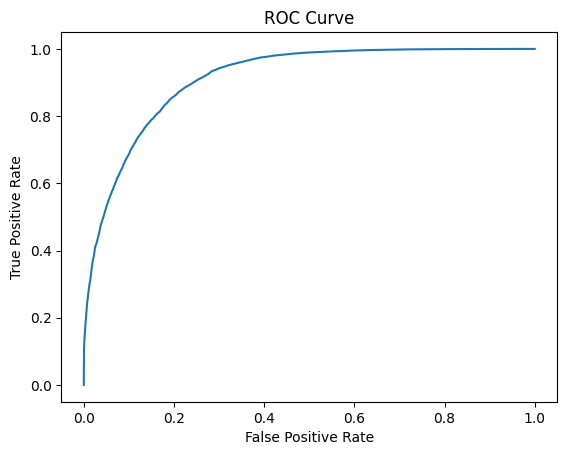

In [ ]:
import matplotlib.pyplot as plt

roc = best_model_lr.summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Decision Tree Classifier benchmark

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

DT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
DT_benchmark = DT.fit(df_train)

train_predictions = DT_benchmark.transform(df_train)
test_predictions = DT_benchmark.transform(df_test.withColumnRenamed('incomeIndex','label'))

print(f"Train accuracy: {Accuracy_calc.evaluate(train_predictions):.3f}")
print(f"Train F1_score: {F1_calc.evaluate(train_predictions):.3f}")
print(f"Train AU-ROC: {AU_ROC_calc.evaluate(train_predictions):.3f}")
#print(f"Recall for class 0: {DT_benchmark.summary.recallByLabel[0]:.3f} for class 1: {DT_benchmark.summary.recallByLabel[0]:.3f}")
#print(f"Precision for class 0: {DT_benchmark.summary.precisionByLabel[0]:.3f} for class 1: {DT_benchmark.summary.precisionByLabel[0]:.3f}")
print('\n')
print(f"Test AU-ROC {AU_ROC_calc.evaluate(test_predictions):.3f}")
print(f"Test accuracy {Accuracy_calc.evaluate(test_predictions):.3f}")
print(f"Test F1_score {F1_calc.evaluate(test_predictions):.3f}")

Train accuracy: 0.824
Train F1_score: 0.822
Train AU-ROC: 0.834


Test AU-ROC 0.827
Test accuracy 0.764
Test F1_score 0.782


In [ ]:
DT_tuned = DecisionTreeClassifier(featuresCol='features', labelCol='label')


paramGrid = (ParamGridBuilder()
    .addGrid(DT_tuned.maxDepth, [5, 10, 15])
    .addGrid(DT_tuned.maxBins, [32, 64, 128])
    .addGrid(DT_tuned.minInstancesPerNode, [1, 2, 4])
    .addGrid(DT_tuned.impurity, ['gini', 'entropy']).build())

crossval = CrossValidator(estimator=DT_tuned,
                          estimatorParamMaps=paramGrid,
                          evaluator=AU_ROC_calc,
                          numFolds=5,
                          parallelism=4)

cv_DT_Model = crossval.fit(df_train)


In [ ]:
for params, metric in zip(paramGrid, cv_DT_Model.avgMetrics):
    print(f"Params: {params}, Metric: {metric}")

Params: {Param(parent='DecisionTreeClassifier_9a02ae462388', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='DecisionTreeClassifier_9a02ae462388', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 32, Param(parent='DecisionTreeClassifier_9a02ae462388', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='DecisionTreeClassifier_9a02ae462388', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini'}, Metric: 0.8029652235338827
Params: {Param(parent='DecisionTreeClassifier_9a02ae462388',

In [ ]:
best_model_DT = cv_DT_Model.bestModel

# Get the parameters of the best model
best_model_params = best_model_DT.extractParamMap()

print("Parameters of the Best Model:")
for param, value in best_model_params.items():
    print(f"{param.name}: {value}")

Parameters of the Best Model:
cacheNodeIds: False
checkpointInterval: 10
featuresCol: features
impurity: entropy
labelCol: label
leafCol: 
maxBins: 128
maxDepth: 15
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 3683280828326119655


In [ ]:
train_predictions = best_model_DT.transform(df_train)
test_predictions = best_model_DT.transform(df_test.withColumnRenamed('incomeIndex','label'))

print(f"Train accuracy: {Accuracy_calc.evaluate(train_predictions):.3f}")
print(f"Train F1_score: {F1_calc.evaluate(train_predictions):.3f}")
print(f"Train AU-ROC: {AU_ROC_calc.evaluate(train_predictions):.3f}")

print('\n')
print(f"Test AU-ROC {AU_ROC_calc.evaluate(test_predictions):.3f}")
print(f"Test accuracy {Accuracy_calc.evaluate(test_predictions):.3f}")
print(f"Test F1_score {F1_calc.evaluate(test_predictions):.3f}")

Train accuracy: 0.897
Train F1_score: 0.897
Train AU-ROC: 0.868


Test AU-ROC 0.823
Test accuracy 0.811
Test F1_score 0.821


In [ ]:
from pyspark.ml.classification import RandomForestClassifier


RF = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
RF_benchmark = RF.fit(df_train)

train_predictions = RF_benchmark.transform(df_train)
test_predictions = RF_benchmark.transform(df_test.withColumnRenamed('incomeIndex','label'))

print(f"Train accuracy: {Accuracy_calc.evaluate(train_predictions):.3f}")
print(f"Train F1_score: {F1_calc.evaluate(train_predictions):.3f}")
print(f"Train AU-ROC: {AU_ROC_calc.evaluate(train_predictions):.3f}")
#print(f"Recall for class 0: {DT_benchmark.summary.recallByLabel[0]:.3f} for class 1: {DT_benchmark.summary.recallByLabel[0]:.3f}")
#print(f"Precision for class 0: {DT_benchmark.summary.precisionByLabel[0]:.3f} for class 1: {DT_benchmark.summary.precisionByLabel[0]:.3f}")
print('\n')
print(f"Test AU-ROC {AU_ROC_calc.evaluate(test_predictions):.3f}")
print(f"Test accuracy {Accuracy_calc.evaluate(test_predictions):.3f}")
print(f"Test F1_score {F1_calc.evaluate(test_predictions):.3f}")

Train accuracy: 0.787
Train F1_score: 0.785
Train AU-ROC: 0.888


Test AU-ROC 0.867
Test accuracy 0.722
Test F1_score 0.743


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

AU_ROC_calc = BinaryClassificationEvaluator(metricName='areaUnderROC',labelCol='label')
Accuracy_calc = MulticlassClassificationEvaluator(metricName='accuracy',labelCol='label')
F1_calc = MulticlassClassificationEvaluator(metricName='f1')

RF_tuned = RandomForestClassifier(labelCol="label", featuresCol="features")

paramGrid = ParamGridBuilder() \
    .addGrid(RF_tuned.maxDepth, [5, 15]) \
    .addGrid(RF_tuned.numTrees, [20, 50]) \
    .addGrid(RF_tuned.featureSubsetStrategy, ['auto', 'sqrt', 'log2']) \
    .addGrid(RF_tuned.subsamplingRate, [0.6, 0.8]) \
    .build()


crossval = CrossValidator(estimator=RF_tuned,
                          estimatorParamMaps=paramGrid,
                          evaluator=AU_ROC_calc,
                          numFolds=5,
                          parallelism=4)

cv_RF_Model = crossval.fit(df_train)

In [ ]:
for params, metric in zip(paramGrid, cv_RF_Model.avgMetrics):
    print(f"Params: {params}, Metric: {metric}")

Params: {Param(parent='RandomForestClassifier_8082957fa9f3', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_8082957fa9f3', name='numTrees', doc='Number of trees to train (>= 1).'): 20, Param(parent='RandomForestClassifier_8082957fa9f3', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'auto', Param(parent='RandomF

In [ ]:
best_model_RF = cv_RF_Model.bestModel

# Get the parameters of the best model
best_model_params = best_model_RF.extractParamMap()

print("Parameters of the Best Model:")
for param, value in best_model_params.items():
    print(f"{param.name}: {value}")

Parameters of the Best Model:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: sqrt
featuresCol: features
impurity: gini
labelCol: label
leafCol: 
maxBins: 32
maxDepth: 15
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 50
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 5024829977650056700
subsamplingRate: 0.8


In [ ]:
train_predictions = best_model_RF.transform(df_train)
test_predictions = best_model_RF.transform(df_test.withColumnRenamed('incomeIndex','label'))

print(f"Train accuracy: {Accuracy_calc.evaluate(train_predictions):.3f}")
print(f"Train F1_score: {F1_calc.evaluate(train_predictions):.3f}")
print(f"Train AU-ROC: {AU_ROC_calc.evaluate(train_predictions):.3f}")

print('\n')
print(f"Test AU-ROC {AU_ROC_calc.evaluate(test_predictions):.3f}")
print(f"Test accuracy {Accuracy_calc.evaluate(test_predictions):.3f}")
print(f"Test F1_score {F1_calc.evaluate(test_predictions):.3f}")

Train accuracy: 0.878
Train F1_score: 0.878
Train AU-ROC: 0.951


Test AU-ROC 0.903
Test accuracy 0.800
Test F1_score 0.812


## Now let's ensemble and check the model performance

In [ ]:
from pyspark.ml.functions import vector_to_array
def extract_proababs(dataframe,name):
  return dataframe.select(vector_to_array("probability")[1].alias(name+"_probs")).toPandas()

In [ ]:
from pyspark.ml.classification import GBTClassifier
import pandas as pd

class StackClassifier:
  def __init__(self,base_learners):

    self.base_learners = base_learners
    self.assembler = None

  def extract_probabs(self,dataframe,name):
    return dataframe.select(vector_to_array("probability")[1].alias("probs_"+str(name))).toPandas()

  def intermediate_transform(self,model,i,data):
    return self.extract_probabs(model.transform(data),i)

  def get_sparkdata(self,combined_pandas_list,label_col):
    combined_pandas_data = pd.concat(combined_pandas_list,axis=1)
    feature_cols = combined_pandas_data.columns.values
    combined_pandas_data['label'] = label_col

    spark_dataframe = spark.createDataFrame(combined_pandas_data)

    if self.assembler==None:
      self.assembler = VectorAssembler(inputCols = feature_cols ,outputCol="features")
      transformed = self.assembler.transform(spark_dataframe)
    else:
      transformed = self.assembler.transform(spark_dataframe)
    return transformed


  def fit(self, data):
    Label = data.select('label').toPandas()
    output_pandas_data = []
    self.trained_baselearners = []
    print("Training base models")
    for i,bs in enumerate(self.base_learners):
      print("Training model number: ",i+1)
      model = bs.fit(data)
      output_pandas_data.append(self.intermediate_transform(model,i,data))
      #print(Accuracy_calc.evaluate(model.transform(data)))
      self.trained_baselearners.append(model)

    final_data = self.get_sparkdata(output_pandas_data,Label)

    self.gbtClassifier = GBTClassifier()
    print("Training the meta classifier")
    self.gbt_model = self.gbtClassifier.fit(final_data)


  def transform(self,data):
    Label = data.select('label').toPandas()
    output_pandas_data = []
    for i,bs in enumerate(self.trained_baselearners):
      #print(Accuracy_calc.evaluate(bs.transform(data)))
      output_pandas_data.append(self.intermediate_transform(bs,i,data))

    final_data = self.get_sparkdata(output_pandas_data,Label)

    return self.gbt_model.transform(final_data)


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier

base_LR = LogisticRegression(featuresCol = 'features', labelCol = 'label',
                             aggregationDepth = 2,
                             elasticNetParam = 0.0,
                             regParam = 0.0,
                             standardization = True,
                             threshold =  0.5,
                             tol =  1e-06,
                             maxIter = 100)

base_DT = DecisionTreeClassifier(featuresCol='features', labelCol='label',
                                 checkpointInterval = 10, impurity = 'entropy',
                                 maxBins = 128, maxDepth = 15, minInstancesPerNode = 1 )

base_RF = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',
                                 featureSubsetStrategy = 'sqrt', impurity = 'gini', subsamplingRate = 0.8,
                                 numTrees = 50, maxDepth = 15)

AU_ROC_calc = BinaryClassificationEvaluator(metricName='areaUnderROC',labelCol='label')
Accuracy_calc = MulticlassClassificationEvaluator(metricName='accuracy',labelCol='label')
F1_calc = MulticlassClassificationEvaluator(metricName='f1')


St = StackClassifier([base_LR,base_DT,base_RF])
St.fit(df_train)
train_predicted = St.transform(df_train)

Training base models
Training model number:  1
Training model number:  2
Training model number:  3
Training the meta classifier


In [ ]:
Accuracy_calc.evaluate(train_predicted)

0.9114809576724922

In [ ]:
AU_ROC_calc.evaluate(train_predicted)

0.9744343352760345

In [ ]:
F1_calc.evaluate(train_predicted)

0.911415906885334

In [ ]:
test_predicted = St.transform(df_test.withColumnRenamed('incomeIndex','label'))

In [ ]:
Accuracy_calc.evaluate(test_predicted)

0.8186915887850468

In [ ]:
AU_ROC_calc.evaluate(test_predicted)

0.8698303006202498

In [ ]:
F1_calc.evaluate(test_predicted)

0.8267095886863233